# Training an image classifier from scratch on the Kaggle Trash Images dataset.

### Setup

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import keras_cv
import numpy as np

Using TensorFlow backend


### Data Load and Cleanup

Delete any image that is corrupted and does not contain "JFIF" header

In [3]:
num_skipped = 0

waste_classes = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

for folder_name in waste_classes:
    folder_path = os.path.join("..", "data", "trash_images", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


### Configure Hyper Parameters

In [4]:
num_epochs = 10
image_size = (180, 180)
batch_size = 128
num_classes = len(waste_classes)

### Dataset Generation

Using batch size of 128 and image size of 180x180

In [5]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "../data/trash_images",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Using 505 files for validation.


### Visualizing some of the data

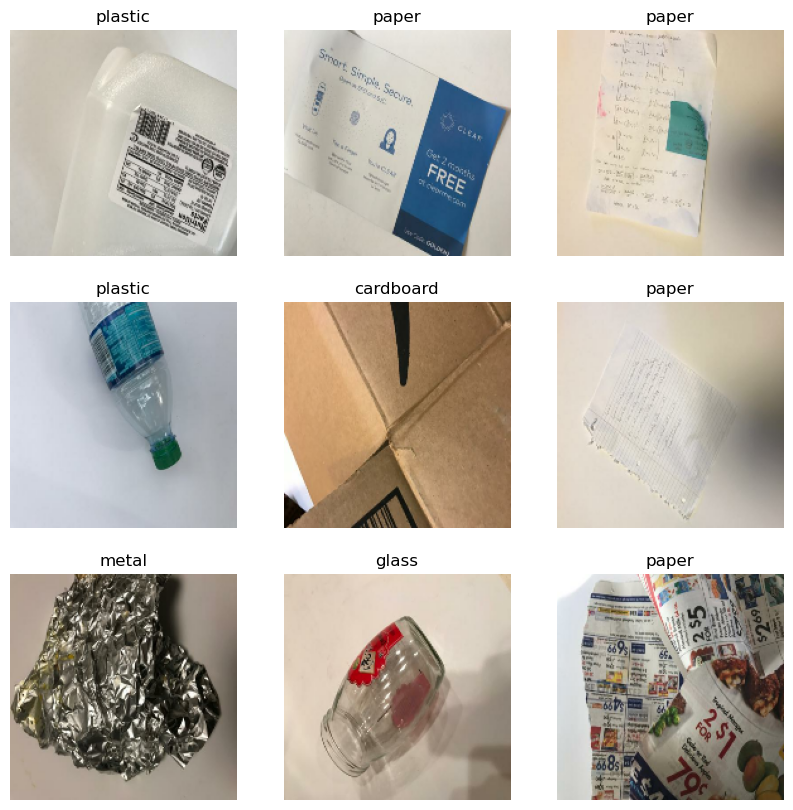

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(waste_classes[labels[i]])
        plt.axis("off")

### Augmenting dataset

Artificially inducing sample diversity by applying transformations to training images. <br>
We apply random flips and rotations to help expose the model to different aspects of training data.

In [7]:
data_augmentation_layers = [
    keras_cv.layers.RandomFlip(),
    keras_cv.layers.RandAugment(
        value_range=(0, 255),
        augmentations_per_image=2,
        magnitude=0.5,
        magnitude_stddev=0.15,
    ),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

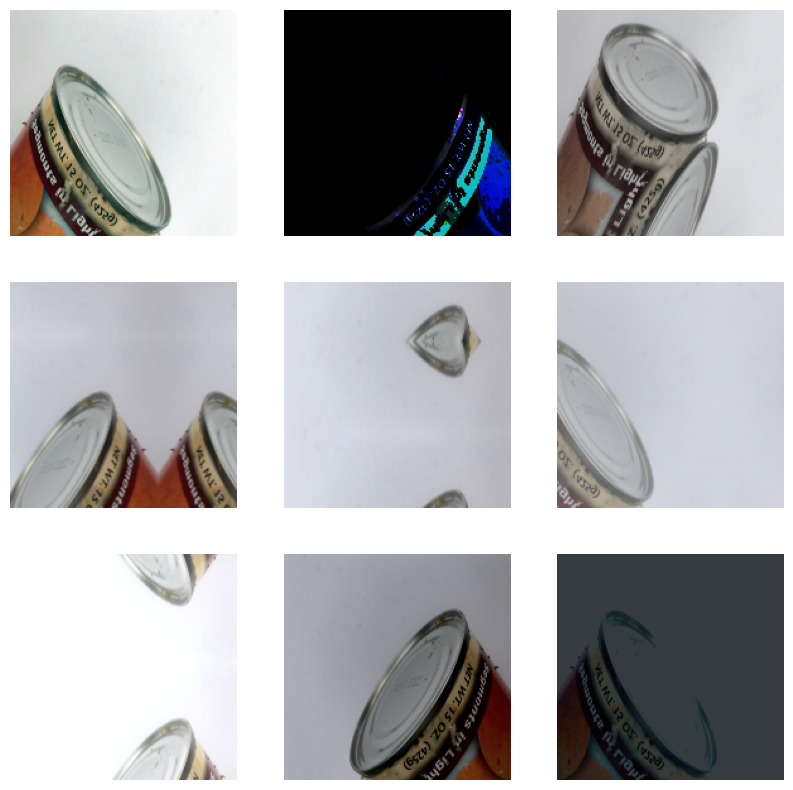

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

### Synchronous Pre-Processing of Images

Attempting to pre-fetch images and apply data augmentation to training data

In [22]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

### Model Construction

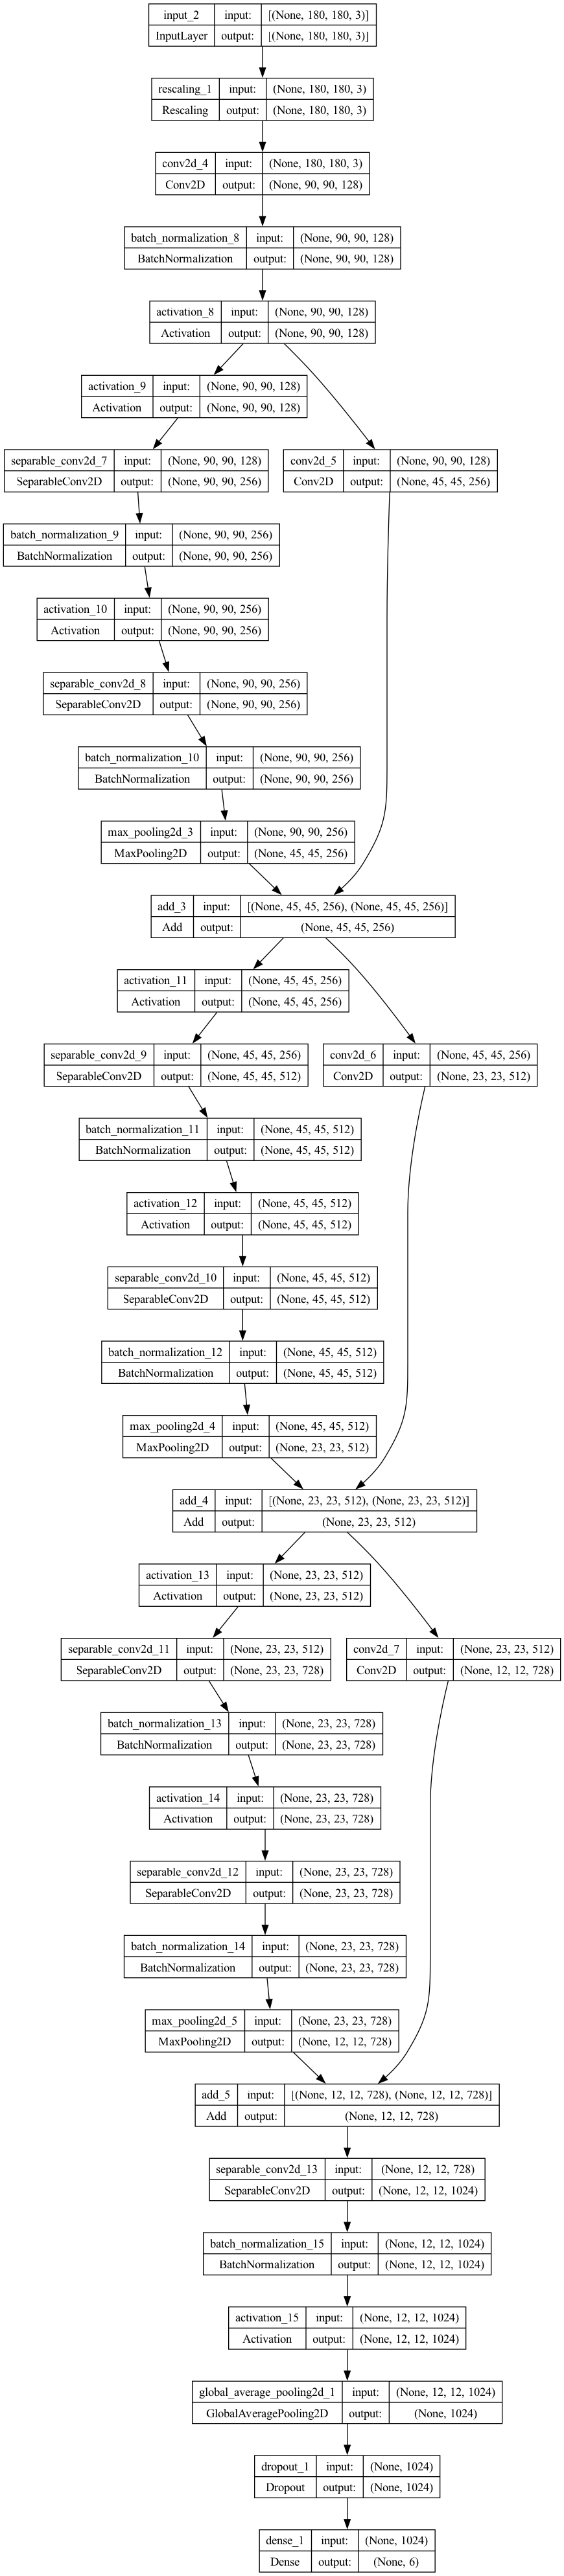

In [23]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=6)
keras.utils.plot_model(model, show_shapes=True)

### Model Training

In [11]:
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=num_epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

model.save(f"model_{num_epochs}_epochs.keras")

Epoch 1/10
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/williamkencel/anaconda3/lib/python3.11/site-packages/tensorflow/python/ops/while_loop.py", line 488, in while_loop
    loop_vars = body(*loop_vars)  File "/Users/williamkencel/anaconda3/lib/python3.11/site-packages/tensorflow/python/ops/while_loop.py", line 479, in <lambda>
    body = lambda i, lv: (i + 1, orig_body(*lv))  File "/Users/williamkencel/anaconda3/lib/python3.11/site-packages/tensorflow/python/ops/map_fn.py", line 495, in compute
    return (i + 1, tas)  File "/Users/williamkencel/anaconda3/lib/python3.11/site-packages/tensorflow/python/ops/map_fn.py", line 492, in <listcomp>
    tas = [  File "/Users/williamkencel/anaconda3/lib/python3.11/site-packages/tensorflow/python/util/tf_should_use.py", line 288, in wrapped


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/williamkencel/anaconda3/lib/python3.11/site-packages/tensorflow/python/ops/while_loop.py", line 488, in while_loop
    loop_vars = body(*loop_vars)  File "/Users/williamkencel/anaconda3/lib/python3.11/site-packages/tensorflow/python/ops/while_loop.py", line 479, in <lambda>
    body = lambda i, lv: (i + 1, orig_body(*lv))  File "/Users/williamkencel/anaconda3/lib/python3.11/site-packages/tensorflow/python/ops/map_fn.py", line 495, in compute
    return (i + 1, tas)  File "/Users/williamkencel/anaconda3/lib/python3.11/site-packages/tensorflow/python/ops/map_fn.py", line 492, in <listcomp>
    tas = [  File "/Users/williamkencel/anaconda3/lib/python3.11/site-packages/tensorflow/python/util/tf_should_use.py", line 288, in wrapped
    return 

16/16 [==============================] - 320s 20s/step - loss: 4.3885 - accuracy: 0.3234 - val_loss: 6.3750 - val_accuracy: 0.0554
Epoch 2/10
 4/16 [======>.......................] - ETA: 4:33 - loss: 2.9441 - accuracy: 0.3027

KeyboardInterrupt: 

### Testing with an image

1/1 [==============================] - 0s 455ms/step
Classified as plastic


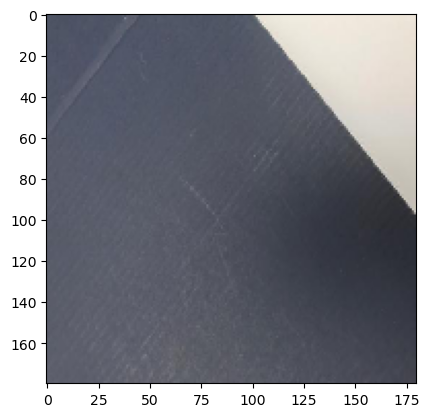

In [24]:
img = keras.utils.load_img(
    "../data/trash_images/cardboard/cardboard_015.jpg", target_size=image_size
)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)

print(f"Classified as {waste_classes[np.argmin(predictions)]}")

### Individual Metrics
This function imports the first model (base CNN) as well as the metrics saved from file and calculates the accuracy for each of our categories of trash. This is done with the validation dataset. The scores are saved off to a dictionary and will be used later.

In [38]:
from keras.models import load_model
import numpy as np

# File holding saved trained model from above
model_path = "saved_models/model_50_epochs.keras"

# Load the model
loaded_model = load_model(model_path)

# Extract true labels from the validation dataset
val_labels = np.concatenate([batch[1].numpy() for batch in val_ds], axis=0)

# Use model to predict labels based on validation data
val_predictions = loaded_model.predict(val_ds)

# Get predicted class labels
predicted_labels = np.argmax(val_predictions, axis=1)

# List of possible categories
categories = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

# Initialize dictionary to store values to be used later
result_dict = {}

# Calculate accuracy score for each category
for i, category in enumerate(categories):
    true_positive = np.sum((predicted_labels == i) & (val_labels == i))
    total_true = np.sum(val_labels == i)
    accuracy = true_positive / total_true if total_true > 0 else 0.0

    # Save values off to the result_dict and print out
    result_dict[f"{category}"] = accuracy
    print(f"Category {category} Accuracy: {accuracy}")

4/4 [==============================] - 11s 3s/step
Category cardboard Accuracy: 0.0
Category glass Accuracy: 0.0
Category metal Accuracy: 0.0
Category paper Accuracy: 0.9473684210526315
Category plastic Accuracy: 0.22727272727272727
Category trash Accuracy: 0.0


## Attempting EfficientNetV2Backbone Instead

### Preprocessing with improved augmentation

In [26]:
augmenter = keras_cv.layers.Augmenter(
    [
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.RandAugment(value_range=(0, 255)),
        keras_cv.layers.CutMix(),
    ],
)


def preprocess_data(images, labels, augment=False):
    labels = tf.one_hot(labels, num_classes)
    if augment:
        # Create a dictionary with "images" and "labels" keys
        outputs = {"images": images, "labels": labels}

        # Apply augmentations to the dictionary
        outputs = augmenter(outputs)

        # Return augmented images and labels
        return outputs["images"], outputs["labels"]

    return images, labels

In [27]:
# Apply preprocessing and augmentations to the train dataset
effnet_train_dataset = (
    train_ds.map(
        lambda x, y: preprocess_data(x, y, augment=True),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# Apply preprocessing to the validation dataset without augmentations
effnet_test_dataset = (
    val_ds.map(
        lambda x, y: preprocess_data(x, y, augment=False),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

### Use EfficientNetV2Backbone as the backbone

In [28]:
# Create a model using a pretrained backbone
effnet_backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(
    "efficientnetv2_b0_imagenet"
)
effnet_model = keras_cv.models.ImageClassifier(
    backbone=effnet_backbone,
    num_classes=num_classes,
    activation="softmax",
)
effnet_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=["accuracy"],
)
# Adding this because this optimizer runs slowly on a the M1/M2 chips on a mac
effnet_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5),
    metrics=["accuracy"],
)

### Train the model

In [29]:
# Train your model
effnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=num_epochs,
)

effnet_model.save(f"effnet_{num_epochs}_model.h5")

Epoch 1/10
 1/16 [>.............................] - ETA: 2:25 - loss: 1.7567 - accuracy: 0.2266

KeyboardInterrupt: 

1/1 [==============================] - 1s 815ms/step


/Users/williamkencel/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Classified as trash


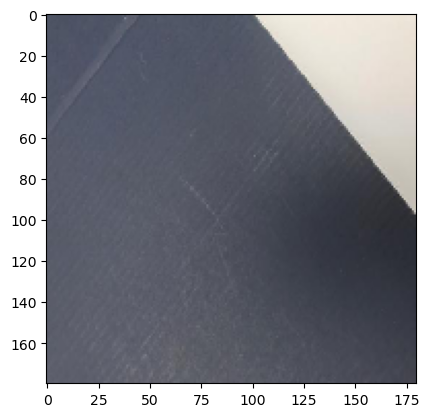

In [30]:
img = keras.utils.load_img(
    "../data/trash_images/cardboard/cardboard_015.jpg", target_size=image_size
)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = effnet_model.predict(img_array)
effnet_model.save("effnet_50_epochs.h5")
print(f"Classified as {waste_classes[np.argmin(predictions)]}")

### Effnet Categorical Accuracy
This function imports the effnet trained model as well as the metrics saved from file and calculates the accuracy for each of our categories of trash. This is done with the validation dataset. The scores are saved off to a dictionary and will be used later.


In [31]:
import numpy as np
from keras.utils import custom_object_scope


# Needed to load the effnet model since it uses a custom backbone function that's not
# preloaded into the keras load_model function
class EfficientNetV2Backbone(keras_cv.models.EfficientNetV2Backbone):
    pass


class ImageClassifier(keras_cv.models.ImageClassifier):
    pass


effnet_model_path = "saved_models/effnet_50_model.h5"
with custom_object_scope(
    {
        "ImageClassifier": ImageClassifier,
        "EfficientNetV2Backbone": EfficientNetV2Backbone,
    }
):
    effnet_model = tf.keras.models.load_model(effnet_model_path)

# Get true labels from the validation dataset
val_labels = np.concatenate([batch[1].numpy() for batch in val_ds], axis=0)

# Make predictions on the validation dataset
val_predictions = effnet_model.predict(val_ds)

# Get predicted class indices
predicted_labels = np.argmax(val_predictions, axis=1)

categories = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

# Initialize Dictionary to store metrics
effnet_category_metrics = {}

# Calculate accuracy for each category
for i, category in enumerate(categories):
    true_positive = np.sum((predicted_labels == i) & (val_labels == i))
    total_true = np.sum(val_labels == i)
    accuracy = true_positive / total_true if total_true > 0 else 0.0

    # Save off and print metrics
    effnet_category_metrics[f"{category}"] = accuracy
    print(f"Category {category} Accuracy: {accuracy:.4f}")

4/4 [==============================] - 4s 699ms/step
Category cardboard Accuracy: 0.8267
Category glass Accuracy: 0.9109
Category metal Accuracy: 0.6914
Category paper Accuracy: 0.8947
Category plastic Accuracy: 0.7955
Category trash Accuracy: 0.1852


### Graphing Metrics between different models
This function creates graphs of the accuracy, loss, and comparison between the two CNN models. It saves them to png files that can be referenced later.

In [32]:
import tensorflow as tf
from matplotlib import pyplot as plt
import pickle
from keras.utils import custom_object_scope
import keras_cv


# Needed to load the effnet model since it uses a custom function
class EfficientNetV2Backbone(keras_cv.models.EfficientNetV2Backbone):
    pass


class ImageClassifier(keras_cv.models.ImageClassifier):
    pass


# Load the saved models
model_path = "saved_models/model_50_epochs.keras"
effnet_model_path = "saved_models/effnet_50_model.h5"
model = tf.keras.models.load_model(model_path)

with custom_object_scope(
    {
        "ImageClassifier": ImageClassifier,
        "EfficientNetV2Backbone": EfficientNetV2Backbone,
    }
):
    effnet_model = tf.keras.models.load_model(effnet_model_path)

# Load the training history, saved models don't contain the metrics from the history value assignment, these need to be saved and loaded separately.
with open("saved_models/first_training_history.pkl", "rb") as file:
    loaded_history = pickle.load(file)

with open("saved_models/effnet_training_history.pkl", "rb") as file:
    effnet_loaded_history = pickle.load(file)

# Access loaded training history
loaded_training_accuracy = loaded_history["accuracy"]
loaded_validation_loss = loaded_history["loss"]
effnet_loaded_training_accuracy = effnet_loaded_history["accuracy"]
effnet_loaded_training_loss = effnet_loaded_history["loss"]

# Epoch vars
epochs = range(1, len(loaded_training_accuracy) + 1)
effnet_epochs = range(1, len(effnet_loaded_training_accuracy) + 1)

# Plot Model 1 accuracy
plt.plot(
    epochs, loaded_training_accuracy, "lightseagreen", label="Model 1 Training Accuracy"
)
plt.title("Model 1 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("metrics/model1_accuracy.png")
# Clear plot
plt.clf()

# Plot Model 2 accuracy
plt.plot(
    effnet_epochs,
    effnet_loaded_training_accuracy,
    "lightseagreen",
    label="Effnet Training Accuracy",
)
plt.title("Model 2 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("metrics/model2_accuracy.png")
# Clear plot
plt.clf()

# Plot Model 1 Loss
plt.plot(epochs, loaded_validation_loss, "darkslategrey", label="Model 1 Training Loss")
plt.title("Model 1 Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("metrics/model1_loss.png")
# Clear plot
plt.clf()

# Plot Model 2 loss
plt.plot(
    effnet_epochs, effnet_loaded_training_loss, "darkslategrey", label="Effnet Loss"
)
plt.title("Model 2 Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("metrics/model2_loss.png")
# Clear plot
plt.clf()

# Plot Model 1 loss and accuracy
plt.plot(
    epochs, loaded_training_accuracy, "lightseagreen", label="Model 1 Training Accuracy"
)
plt.plot(epochs, loaded_validation_loss, "darkslategrey", label="Model 1 Training Loss")
plt.title("Model 1 Accuracy vs Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy/Loss")
plt.legend()
plt.savefig("metrics/model1_accuracy_and_loss.png")
# Clear plot
plt.clf()

# Plot Model 2 loss and accuracy
plt.plot(
    effnet_epochs,
    effnet_loaded_training_accuracy,
    "lightseagreen",
    label="Effnet Training Accuracy",
)
plt.plot(
    effnet_epochs, effnet_loaded_training_loss, "darkslategrey", label="Effnet Loss"
)
plt.title("Model 2 Accuracy vs Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy/Loss")
plt.legend()
plt.savefig("metrics/model2_accuracy_and_loss.png")
# Clear plot
plt.clf()

# Plot Model 1 & 2 accuracy
plt.plot(epochs, loaded_training_accuracy, "blue", label="Model 1 Training Accuracy")
plt.plot(
    effnet_epochs,
    effnet_loaded_training_accuracy,
    "red",
    label="Effnet Training Accuracy",
)
plt.title("Model 1 Accuracy vs Model 2 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("metrics/model1_accuracy_vs_mode2_accuracy.png")
# Clear plot
plt.clf()

# Plot Model 1 & 2 loss
plt.plot(epochs, loaded_validation_loss, "blue", label="Model 1 Training Loss")
plt.plot(
    effnet_epochs, effnet_loaded_training_loss, "red", label="Effnet Training Loss"
)
plt.title("Model 1 Loss vs Model 2 Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("metrics/model1_loss_vs_mode2_loss.png")
# Clear plot
plt.clf()

<Figure size 640x480 with 0 Axes>

### Plot Categorical Accuracy Between Random Forest and the two CNN models
This function takes the categorical accuracy scores across all the trained models and compares which categories were easier/harder to classify. It saves off the graph as a png file into the metrics folder.

                    model  loss  accuracy  precision  f1_score  \
0  RandomForestClassifier   NaN   0.72332   0.730547  0.694092   

   accuracy_for_glass  accuracy_for_metal  accuracy_for_cardboard  \
0            0.722222            0.578947                0.776596   

   accuracy_for_plastic  accuracy_for_paper  accuracy_for_trash  
0              0.688172            0.846154            0.444444  


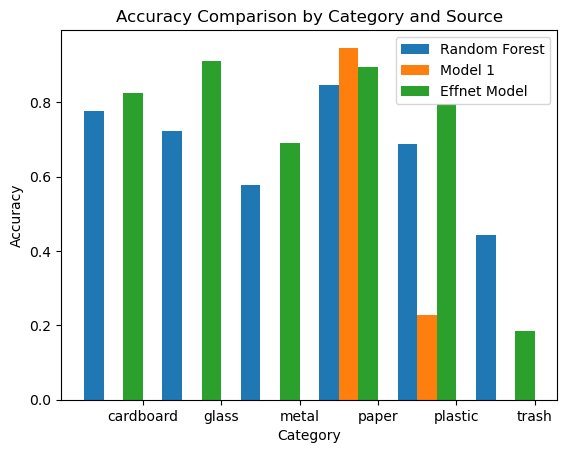

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Get categorical accuracy values from random forest metrics csv file
random_forest_metrics = pd.read_csv("../src/model_metrics.csv")
print(random_forest_metrics)
random_forest_dict = {}

# Gather accuracy measures from random forest csv
for category in categories:
    column_name = f"accuracy_for_{category}"
    random_forest_dict[category] = random_forest_metrics[column_name].values[0]

# Initialize the categories using keys from random_forest
categories = list(random_forest_dict.keys())

# Create bar plot to compare categories across models
bar_width = 0.25
index = np.arange(len(categories))

# Create numpy array for each model to make plotting easier
random_forest_data = np.array([random_forest_dict[category] for category in categories])
model_1_data = np.array([result_dict[category] for category in categories])
effnet_data = np.array([effnet_category_metrics[category] for category in categories])

# Individually plot the data
plt.bar(index - bar_width, random_forest_data, width=bar_width, label="Random Forest")
plt.bar(index, model_1_data, width=bar_width, label="Model 1")
plt.bar(index + bar_width, effnet_data, width=bar_width, label="Effnet Model")

# Create labels and show plot
plt.xlabel("Category")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison by Category and Source")
plt.xticks(index + bar_width * 1.5, categories)
plt.legend()
plt.savefig("metrics/categorical_comparison.png")